In [1]:
import math

import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm
import time
import baostock as bs

In [176]:
trading_signal = pd.read_csv('trading_signal_CSI_80.csv', dtype={'Time': 'str'})
trading_signal['Time'] = pd.to_datetime(trading_signal['Time'])
trading_signal = trading_signal.set_index('Time').sort_index()

to_delete = []


# 遍历 DataFrame 找到需要删除的信号
for pair in trading_signal['Pair'].unique():
    # 获取特定交易对的信号
    pair_signals = trading_signal[trading_signal['Pair'] == pair]
    # 排序以确保信号按时间顺序排列
    pair_signals = pair_signals.sort_index()

    # 添加调试信息

    # 确保至少有两个信号
    if len(pair_signals) > 1:
        for i in range(len(pair_signals) - 1):
            # 检查是否符合条件
            if (
                (pair_signals.iloc[i]['Signal'] == 'Close-Buy' and
                 pair_signals.iloc[i+1]['Signal'] == 'Buy' and
                 pair_signals.index[i].time() == pd.Timestamp('15:00:00').time() and
                 pair_signals.index[i+1].time() == pd.Timestamp('09:35:00').time() and
                 pair_signals.index[i+1].date() == pair_signals.index[i].date() + pd.Timedelta(days=1))
                or
                (pair_signals.iloc[i]['Signal'] == 'Close-Sell' and
                 pair_signals.iloc[i+1]['Signal'] == 'Sell' and
                 pair_signals.index[i].time() == pd.Timestamp('15:00:00').time() and
                 pair_signals.index[i+1].time() == pd.Timestamp('09:35:00').time() and
                 pair_signals.index[i+1].date() == pair_signals.index[i].date() + pd.Timedelta(days=1))
            ):
                # 添加调试信息

                # 将需要删除的行的唯一标识添加到列表中
                to_delete.append(pair_signals.iloc[i]['Unnamed: 0'])
                to_delete.append(pair_signals.iloc[i+1]['Unnamed: 0'])

# 使用唯一标识来删除这些信号
df_filtered = trading_signal[~trading_signal['Unnamed: 0'].isin(to_delete)].drop(columns=['Unnamed: 0'])


df_filtered = df_filtered[(df_filtered.index >= '2009-01-01')&(df_filtered.index <= '2022-01-01')]

In [122]:
df_filtered

,Signal,Pair
Time,,
2009-02-26 09:35:00,Sell,sh.600362-sh.600548
2009-02-26 09:35:00,Buy,sh.600535-sz.000528
2009-02-26 09:35:00,Sell,sh.600331-sz.000088
2009-02-26 09:35:00,Buy,sh.600066-sh.600787
2009-02-26 09:35:00,Sell,sh.600331-sh.600597
...,...,...
2021-12-29 09:35:00,Buy,sh.600489-sh.600989
2021-12-29 09:35:00,Buy,sh.601229-sz.300033
2021-12-29 09:35:00,Sell,sh.600011-sh.601229


In [101]:
len(trading_signal[trading_signal['Pair'] == 'sh.600835-sh.601088'])

2

In [177]:
def get_trade_signal_sequences(df_signals):
    trade_sequences = {}
    for pair in df_signals['Pair'].unique():
        pair_signals = df_signals[df_signals['Pair'] == pair].sort_index()
        trade_sequences[pair] = []
        for i in range(0, len(pair_signals), 2):
            if i+1 < len(pair_signals):
                entry_signal = pair_signals.iloc[i]
                exit_signal = pair_signals.iloc[i+1]
                trade_sequences[pair].append((entry_signal, exit_signal))
    return trade_sequences

trade_sequences = get_trade_signal_sequences(df_filtered)
trade_sequences

{'sh.600638-sh.600748': [(Signal                    Buy
   Pair      sh.600638-sh.600748
   Name: 2009-04-24 09:35:00, dtype: object,
   Signal              Close-Buy
   Pair      sh.600638-sh.600748
   Name: 2009-05-08 15:00:00, dtype: object)],
 'sh.600685-sh.601398': [(Signal                   Sell
   Pair      sh.600685-sh.601398
   Name: 2009-04-24 09:35:00, dtype: object,
   Signal             Close-Sell
   Pair      sh.600685-sh.601398
   Name: 2009-05-08 15:00:00, dtype: object)],
 'sh.600628-sz.000581': [(Signal                    Buy
   Pair      sh.600628-sz.000581
   Name: 2009-04-24 09:35:00, dtype: object,
   Signal              Close-Buy
   Pair      sh.600628-sz.000581
   Name: 2009-05-08 15:00:00, dtype: object)],
 'sh.600150-sh.601398': [(Signal                   Sell
   Pair      sh.600150-sh.601398
   Name: 2009-04-24 09:35:00, dtype: object,
   Signal             Close-Sell
   Pair      sh.600150-sh.601398
   Name: 2009-05-08 15:00:00, dtype: object)],
 'sh.600748-

In [97]:
trade_sequences['sh.600085-sh.600835']

[(Signal                   Sell
  Pair      sh.600085-sh.600835
  Name: 2008-04-01 09:35:00, dtype: object,
  Signal             Close-Sell
  Pair      sh.600085-sh.600835
  Name: 2008-04-08 15:00:00, dtype: object),
 (Signal                   Sell
  Pair      sh.600085-sh.600835
  Name: 2008-04-09 14:20:00, dtype: object,
  Signal             Close-Sell
  Pair      sh.600085-sh.600835
  Name: 2008-04-15 15:00:00, dtype: object),
 (Signal                   Sell
  Pair      sh.600085-sh.600835
  Name: 2008-05-13 09:50:00, dtype: object,
  Signal             Close-Sell
  Pair      sh.600085-sh.600835
  Name: 2008-05-15 15:00:00, dtype: object)]

In [178]:
def get_price_with_retry(stock, start_time, end_time, max_retries=100):
    retries = 0
    while retries < max_retries:
        try:
            rs = bs.query_history_k_data_plus(stock,
                                              "time,code,close",
                                              start_date=start_time, end_date=end_time,
                                              frequency="5", adjustflag="2")

            data_list = []
            while (rs.error_code == '0') & rs.next():
                # 获取一条记录，将记录合并在一起
                data_list.append(rs.get_row_data())
            result = pd.DataFrame(data_list, columns=rs.fields)
            result['close'] = result['close'].astype(float)
            return result
        except Exception as e:
            print(f"Error occurred: {e}. Retrying in 1 seconds...")
            time.sleep(1)
            retries += 1
    raise Exception("Max retries exceeded. Failed to fetch data.")



def calculate_value_series(trade_sequences, transaction_cost=0.0001):
    value_series_dict = {}
    for pair, sequences in trade_sequences.items():
        stock1, stock2 = pair.split('-')
        value_series_dict[pair] = []
        for entry_signal, exit_signal in sequences:
            start_datetime = entry_signal.name
            end_datetime = exit_signal.name
            start_date = start_datetime.strftime('%Y-%m-%d')
            end_date = end_datetime.strftime('%Y-%m-%d')
            bs.login()
            data_stock1 = get_price_with_retry(stock1, start_date, end_date)
            data_stock2 = get_price_with_retry(stock2, start_date, end_date)
            bs.logout()

            # 合并数据
            merged_data = pd.merge(data_stock1, data_stock2, on='time', suffixes=('_1', '_2'))
            merged_data['time'] = pd.to_datetime(merged_data['time'], format='%Y%m%d%H%M%S%f')
            merged_data.set_index('time', inplace=True)

            # 筛选出在开仓和平仓时间范围内的数据
            filtered_data = merged_data[(merged_data.index >= start_datetime) & (merged_data.index <= end_datetime)].copy()

            if filtered_data.empty or len(filtered_data) < 2:
                print(f"Not enough data for pair {pair} between {start_datetime} and {end_datetime}")
                continue

            filtered_data.loc[:, 'value'] = filtered_data['close_1'] - filtered_data['close_2']

            # 计算开仓和平仓的交易成本
            try:
                entry_cost = (filtered_data['close_1'].iloc[0] + filtered_data['close_2'].iloc[0]) * transaction_cost
                exit_cost = (filtered_data['close_1'].iloc[-1] + filtered_data['close_2'].iloc[-1]) * transaction_cost
            except IndexError:
                print(f"Index error for pair {pair} between {start_datetime} and {end_datetime}")
                continue

            value_series_dict[pair].append((entry_signal.name, filtered_data['value'], filtered_data.index, entry_cost, exit_cost))
    return value_series_dict


value_series_dict = calculate_value_series(trade_sequences)

login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login success!
logout success!
login su

In [96]:
value_series_dict['sh.600085-sh.600835']

[(Timestamp('2008-04-01 09:35:00'),
  time
  2008-04-01 09:35:00   -5.649951
  2008-04-01 09:40:00   -5.665753
  2008-04-01 09:45:00   -5.683555
  2008-04-01 09:50:00   -5.529889
  2008-04-01 09:55:00   -5.511534
                           ...   
  2008-04-08 14:40:00   -5.748554
  2008-04-08 14:45:00   -5.879932
  2008-04-08 14:50:00   -5.797131
  2008-04-08 14:55:00   -5.907050
  2008-04-08 15:00:00   -5.975430
  Name: value, Length: 240, dtype: float64,
  DatetimeIndex(['2008-04-01 09:35:00', '2008-04-01 09:40:00',
                 '2008-04-01 09:45:00', '2008-04-01 09:50:00',
                 '2008-04-01 09:55:00', '2008-04-01 10:00:00',
                 '2008-04-01 10:05:00', '2008-04-01 10:10:00',
                 '2008-04-01 10:15:00', '2008-04-01 10:20:00',
                 ...
                 '2008-04-08 14:15:00', '2008-04-08 14:20:00',
                 '2008-04-08 14:25:00', '2008-04-08 14:30:00',
                 '2008-04-08 14:35:00', '2008-04-08 14:40:00',
              

In [181]:
import mpmath


def backtest(df_signals, value_series_dict, initial_cash, stop_loss_threshold=1):
    cash = initial_cash
    holdings = {}
    portfolio_values = []
    portfolio_net_values = []
    entry_values = {}  # 记录开仓时的投资组合价值
    cumulative_transaction_cost = 0  # 累积交易成本

    # 获取所有时间点，包括持仓期间的时间点
    all_dates = df_signals.index.unique()
    for value_series in value_series_dict.values():
        for _, _, times, _, _ in value_series:
            all_dates = all_dates.union(times)

    all_dates = all_dates.sort_values()

    for current_time in tqdm(all_dates):
        # 处理开仓和平仓信号
        if current_time in df_signals.index:
            signals_at_time = df_signals.loc[current_time]
            if isinstance(signals_at_time, pd.Series):
                signals_at_time = signals_at_time.to_frame().T
            else:
                signals_at_time = pd.DataFrame(signals_at_time)
            for time_index, row in signals_at_time.iterrows():
                pair = row['Pair']
                signal = row['Signal']
                if signal in ['Buy', 'Sell']:
                    value_series = None
                    entry_cost = 0
                    exit_cost = 0
                    investment = cash / 10
                    for entry_time, series, times, e_cost, x_cost in value_series_dict[pair]:
                        if entry_time == current_time:
                            value_series = series
                            value_times = times
                            entry_cost = e_cost
                            exit_cost = x_cost
                            break

                    if value_series is not None:
                        units = max((math.floor(10000.0/(entry_cost + abs(value_series.iloc[0]))) // 100) * 100,100)
                        # units = max(math.floor((max(10000.0,investment)/(entry_cost + abs(value_series.iloc[0])))//100) * 100 ,100)
                        holdings[pair] = {
                            'units': units if signal == 'Buy' else -units,
                            'value_series': value_series,
                            'times': value_times,
                            'entry_cost': entry_cost,
                            'exit_cost': exit_cost
                        }
                        transaction_cost = units * entry_cost
                        cumulative_transaction_cost += transaction_cost
                        cash -= transaction_cost
                        units = holdings[pair]['units']

                        cash -= units * value_series.iloc[0]
                        entry_values[pair] = units * (value_series.iloc[0] + transaction_cost)

                elif signal in ['Close-Buy', 'Close-Sell']:
                    if pair in holdings:
                        units = holdings[pair]['units']
                        value_series = holdings[pair]['value_series']
                        exit_cost = holdings[pair]['exit_cost']
                        transaction_cost = exit_cost * abs(units)
                        cumulative_transaction_cost += transaction_cost
                        cash -= transaction_cost
                        cash += value_series.iloc[-1] * units
                        del holdings[pair]
                        del entry_values[pair]


        # 计算当前组合价值
        current_value = cash
        for pair, holding in list(holdings.items()):
            units = holding['units']
            value_series = holding['value_series']
            value_times = holding['times']
            if current_time in value_times:

                # 检查是否触发止损
                if pair in entry_values:
                    max_drawdown = (entry_values[pair] - units * value_series.loc[current_time]) / entry_values[pair]
                    if max_drawdown >= stop_loss_threshold:
                        exit_cost = holdings[pair]['exit_cost']
                        transaction_cost = exit_cost * abs(units)
                        cumulative_transaction_cost += transaction_cost
                        cash -= transaction_cost
                        cash += units * value_series.loc[current_time]
                        # print(f'{pair}于{str(current_time)}触发止损')
                        del holdings[pair]
                        del entry_values[pair]
                    else:
                        current_value += units * value_series.loc[current_time]

        portfolio_value = current_value + cumulative_transaction_cost
        portfolio_values.append((current_time, portfolio_value))
        portfolio_net_values.append((current_time, current_value))

    return portfolio_values, portfolio_net_values

portfolio_values, portfolio_net_values = backtest(df_filtered, value_series_dict, 100000.0)

# 转换为DataFrame以便于分析
result_df = pd.DataFrame({
    'Time': [x[0] for x in portfolio_values],
    'Portfolio Value': [x[1] for x in portfolio_values],
    'Net Portfolio Value': [x[1] for x in portfolio_net_values]
})

print(result_df)


100%|██████████| 49566/49566 [00:07<00:00, 6427.23it/s]

                     Time  Portfolio Value  Net Portfolio Value
0     2009-04-24 09:35:00    110146.609380        109998.797663
1     2009-04-24 09:40:00    101495.537654        101347.725937
2     2009-04-24 09:45:00    103493.395977        103345.584260
3     2009-04-24 09:50:00    103069.247183        102921.435466
4     2009-04-24 09:55:00    101571.660224        101423.848507
...                   ...              ...                  ...
49561 2021-10-26 14:40:00     10439.125853        -19549.719275
49562 2021-10-26 14:45:00     10435.178155        -19553.666973
49563 2021-10-26 14:50:00     10302.455978        -19686.389150
49564 2021-10-26 14:55:00     10452.085676        -19536.759452
49565 2021-10-26 15:00:00     10151.899094        -19859.354833

[49566 rows x 3 columns]


In [159]:
def backtest(df_signals, value_series_dict, initial_cash, stop_loss_threshold=0.3):
    cash = initial_cash
    holdings = {}
    portfolio_values = []
    portfolio_net_values = []
    entry_values = {}  # 记录开仓时的投资组合价值
    cumulative_transaction_cost = 0  # 累积交易成本
    max_values = {}  # 记录每个持仓的最大值

    # 获取所有时间点，包括持仓期间的时间点
    all_dates = df_signals.index.unique()
    for value_series in value_series_dict.values():
        for _, _, times, _, _ in value_series:
            all_dates = all_dates.union(times)

    all_dates = all_dates.sort_values()

    for current_time in tqdm(all_dates):
        # 处理开仓和平仓信号
        if current_time in df_signals.index:
            signals_at_time = df_signals.loc[current_time]
            if isinstance(signals_at_time, pd.Series):
                signals_at_time = signals_at_time.to_frame().T
            else:
                signals_at_time = pd.DataFrame(signals_at_time)
            for time_index, row in signals_at_time.iterrows():
                pair = row['Pair']
                signal = row['Signal']
                if signal in ['Buy', 'Sell']:
                    value_series = None
                    entry_cost = 0
                    exit_cost = 0
                    investment = cash / 10
                    for entry_time, series, times, e_cost, x_cost in value_series_dict[pair]:
                        if entry_time == current_time:
                            value_series = series
                            value_times = times
                            entry_cost = e_cost
                            exit_cost = x_cost
                            break

                    if value_series is not None:
                        units = max(math.floor((max(10000.0, investment) / (entry_cost + abs(value_series.iloc[0]))) // 100) * 100, 100)
                        holdings[pair] = {
                            'units': units if signal == 'Buy' else -units,
                            'value_series': value_series,
                            'times': value_times,
                            'entry_cost': entry_cost,
                            'exit_cost': exit_cost
                        }
                        transaction_cost = units * entry_cost
                        cumulative_transaction_cost += transaction_cost
                        cash -= transaction_cost
                        units = holdings[pair]['units']

                        cash -= units * value_series.iloc[0]
                        entry_values[pair] = units * (value_series.iloc[0] + transaction_cost)
                        max_values[pair] = value_series.iloc[0]

                elif signal in ['Close-Buy', 'Close-Sell']:
                    if pair in holdings:
                        units = holdings[pair]['units']
                        value_series = holdings[pair]['value_series']
                        exit_cost = holdings[pair]['exit_cost']
                        transaction_cost = exit_cost * abs(units)
                        cumulative_transaction_cost += transaction_cost
                        cash -= transaction_cost
                        cash += value_series.iloc[-1] * units
                        del holdings[pair]
                        del entry_values[pair]
                        del max_values[pair]

        # 计算当前组合价值
        current_value = cash
        for pair, holding in list(holdings.items()):
            units = holding['units']
            value_series = holding['value_series']
            value_times = holding['times']
            if current_time in value_times:
                # 更新最大值
                current_value_series_value = value_series.loc[current_time]
                if current_value_series_value > max_values[pair]:
                    max_values[pair] = current_value_series_value

                # 检查是否触发止损
                if pair in entry_values:
                    max_drawdown = (max_values[pair] - current_value_series_value) / max_values[pair]
                    if max_drawdown >= stop_loss_threshold:
                        exit_cost = holdings[pair]['exit_cost']
                        transaction_cost = exit_cost * abs(units)
                        cumulative_transaction_cost += transaction_cost
                        cash -= transaction_cost
                        cash += units * current_value_series_value
                        del holdings[pair]
                        del entry_values[pair]
                        del max_values[pair]
                    else:
                        current_value += units * current_value_series_value

        portfolio_value = current_value + cumulative_transaction_cost
        portfolio_values.append((current_time, portfolio_value))
        portfolio_net_values.append((current_time, current_value))

    return portfolio_values, portfolio_net_values

portfolio_values, portfolio_net_values = backtest(df_filtered, value_series_dict, 100000.0)

result_df = pd.DataFrame({
    'Time': [x[0] for x in portfolio_values],
    'Portfolio Value': [x[1] for x in portfolio_values],
    'Net Portfolio Value': [x[1] for x in portfolio_net_values]
})

print(result_df)

100%|██████████| 99619/99619 [00:12<00:00, 8120.74it/s] 


                     Time  Portfolio Value  Net Portfolio Value
0     2009-02-26 09:35:00     1.000000e+05         9.993223e+04
1     2009-02-26 09:40:00     1.025641e+05         1.024963e+05
2     2009-02-26 09:45:00     1.060530e+05         1.059852e+05
3     2009-02-26 09:50:00     1.037927e+05         1.037249e+05
4     2009-02-26 09:55:00     1.046349e+05         1.045672e+05
...                   ...              ...                  ...
99614 2021-12-28 14:55:00    -4.470736e+06        -6.212226e+06
99615 2021-12-28 15:00:00    -4.470707e+06        -6.212206e+06
99616 2021-12-29 09:35:00    -4.470707e+06        -6.212206e+06
99617 2021-12-29 09:50:00    -4.470707e+06        -6.212206e+06
99618 2021-12-29 09:55:00    -4.470707e+06        -6.212206e+06

[99619 rows x 3 columns]


In [126]:
# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)


# 详细指标参数，参见“历史行情指标参数”章节；“周月线”参数与“日线”参数不同。
# 周月线指标：date,code,open,high,low,close,volume,amount,adjustflag,turn,pctChg
rs = bs.query_history_k_data_plus("sh.000300",
    "date,code,close",
    start_date='2009-02-26', end_date='2022-01-27', frequency="d")

# 打印结果集
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
# 结果集输出到csv文件
bs.logout()
result

login success!
login respond error_code:0
login respond  error_msg:success
logout success!


,date,code,close
0,2009-02-26,sh.000300,2190.1850
1,2009-02-27,sh.000300,2140.4890
2,2009-03-02,sh.000300,2164.6660
3,2009-03-03,sh.000300,2142.1540
4,2009-03-04,sh.000300,2285.1490
...,...,...,...
3141,2022-01-21,sh.000300,4779.3142
3142,2022-01-24,sh.000300,4786.7377
3143,2022-01-25,sh.000300,4678.4511
3144,2022-01-26,sh.000300,4712.3109


In [127]:

result['close'] = result['close'].astype(float)
initial_index_value = result.iloc[0]['close']
units_invested = 100000.0 / initial_index_value

# 计算每日的组合价值
result['portfolio_value'] = result['close'] * units_invested

# 选择需要的列进行展示
hs300 = result[['date', 'portfolio_value']].copy()
hs300['date'] = pd.to_datetime(hs300['date'])
hs300

,date,portfolio_value
0,2009-02-26,100000.000000
1,2009-02-27,97730.967932
2,2009-03-02,98834.847285
3,2009-03-03,97806.988907
4,2009-03-04,104335.889434
...,...,...
3141,2022-01-21,218215.091419
3142,2022-01-24,218554.035390
3143,2022-01-25,213609.859441
3144,2022-01-26,215155.838434


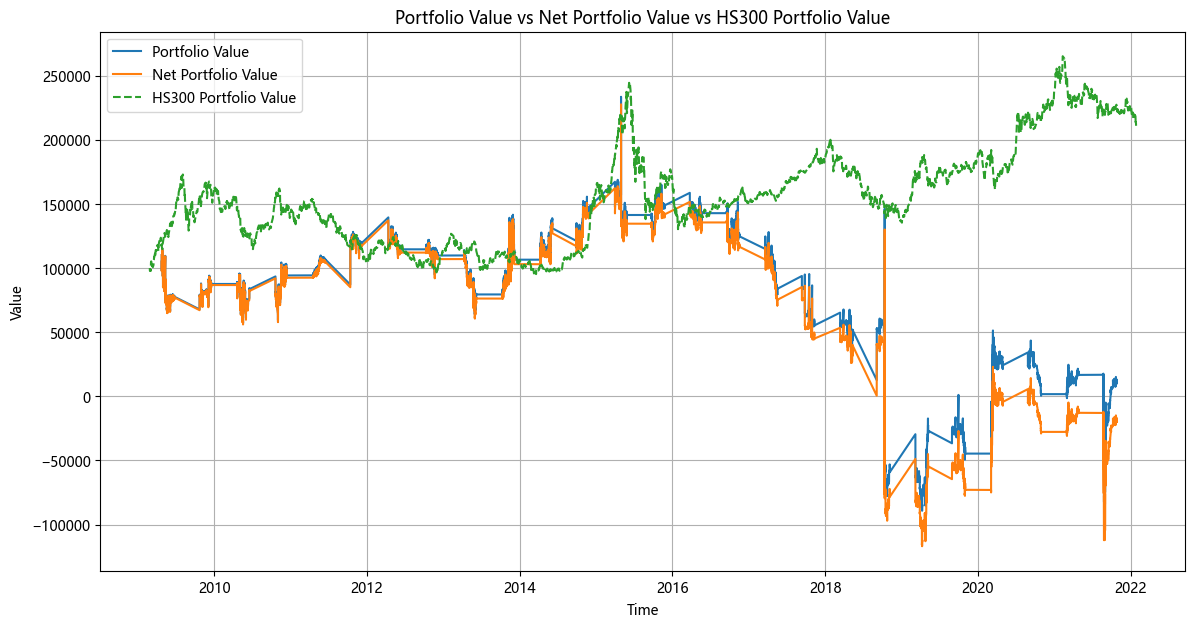

In [182]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(result_df['Time'], result_df['Portfolio Value'], label='Portfolio Value')
plt.plot(result_df['Time'], result_df['Net Portfolio Value'], label='Net Portfolio Value')
plt.plot(hs300['date'], hs300['portfolio_value'], label='HS300 Portfolio Value', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Portfolio Value vs Net Portfolio Value vs HS300 Portfolio Value')
plt.legend()
plt.grid(True)
plt.savefig('dadsfasdf.jpeg',dpi=300)
plt.show()

In [28]:
print(hs300)

           date  portfolio_value
0    2008-03-04    100000.000000
1    2008-03-05     99091.786430
2    2008-03-06    100297.186045
3    2008-03-07     98941.095422
4    2008-03-10     94871.517665
...         ...              ...
3795 2023-10-12     79260.652842
3796 2023-10-13     78426.339735
3797 2023-10-16     77638.242248
3798 2023-10-17     77912.363299
3799 2023-10-18     77295.275166

[3800 rows x 2 columns]


In [174]:
def calculate_performance_metrics(portfolio_df, benchmark_df, annual_risk_free_rate):
    # 确保日期列为datetime类型
    portfolio_df['Time'] = pd.to_datetime(portfolio_df['Time'])
    benchmark_df['date'] = pd.to_datetime(benchmark_df['date'])

    # 将分钟级别数据重新采样为日度数据
    daily_portfolio = portfolio_df.set_index('Time')['Portfolio Value'].resample('D').last().pct_change().dropna()

    # 计算基准的日度收益率
    daily_benchmark = benchmark_df.set_index('date')['portfolio_value'].pct_change().dropna()

    # 对齐两个数据集，确保日期匹配
    merged_df = pd.concat([daily_portfolio, daily_benchmark], axis=1).dropna()
    merged_df.columns = ['portfolio_return', 'benchmark_return']

    # 计算每日平均收益率
    daily_mean_return = merged_df['portfolio_return'].mean()

    # 计算每日收益率的标准差
    daily_std_dev = merged_df['portfolio_return'].std()

    # 计算日度无风险利率
    daily_risk_free_rate = (1 + annual_risk_free_rate / 100) ** (1 / 252) - 1

    # 计算夏普比率
    excess_daily_returns = merged_df['portfolio_return'] - daily_risk_free_rate
    sharpe_ratio = excess_daily_returns.mean() / daily_std_dev

    # 计算信息比率
    active_returns = merged_df['portfolio_return']
    tracking_error = active_returns.std()
    information_ratio = active_returns.mean() / tracking_error

    # 计算年化夏普比率和信息比率
    annual_sharpe_ratio = sharpe_ratio * (252 ** 0.5)
    annual_information_ratio = information_ratio * (252 ** 0.5)

    return {
        'daily_mean_return': daily_mean_return,
        'annual_sharpe_ratio': annual_sharpe_ratio,
        'annual_information_ratio': annual_information_ratio
    }

In [175]:
statistic = calculate_performance_metrics(result_df,hs300,2)
print(statistic)

{'daily_mean_return': -0.00021395406991937135, 'annual_sharpe_ratio': -0.028945878715518496, 'annual_information_ratio': -0.021170128791607352}


C:\Users\Win\AppData\Local\Temp\ipykernel_25548\1589104420.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_portfolio = portfolio_df.set_index('Time')['Portfolio Value'].resample('D').last().pct_change().dropna()
